<a href="https://colab.research.google.com/github/Reenato94/TECH_FASE4/blob/main/Analises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn import metrics
from statsmodels.tools.eval_measures import rmse
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import joblib

In [ ]:
df = pd.read_csv('/content/dados_ipeadata.csv', sep=';', encoding='ISO-8859-1')

print(df.head())

df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
df['Preço'] = df['Preço'].str.replace(',', '.').astype(float)


         Data  Preço
0  20/05/1987  18,63
1  21/05/1987  18,45
2  22/05/1987  18,55
3  25/05/1987   18,6
4  26/05/1987  18,63


In [ ]:
df = df.rename(columns={'Data': 'ds', 'Preço': 'y'})

print(df.head())

          ds      y
0 1987-05-20  18.63
1 1987-05-21  18.45
2 1987-05-22  18.55
3 1987-05-25  18.60
4 1987-05-26  18.63


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11292 entries, 0 to 11291
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      11292 non-null  datetime64[ns]
 1   y       11292 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 176.6 KB


In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
train = df.iloc[:-365]
test = df.iloc[-365:]

1º Modelo:

In [ ]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgq4rchxy/09cp4mee.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgq4rchxy/b02cqru9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46911', 'data', 'file=/tmp/tmpgq4rchxy/09cp4mee.json', 'init=/tmp/tmpgq4rchxy/b02cqru9.json', 'output', 'file=/tmp/tmpgq4rchxy/prophet_model16ec9ck1/prophet_model-20241130175028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:50:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
11652,2025-10-31,93.998319,79.311797,109.342739
11653,2025-11-01,94.261472,79.243752,109.863399
11654,2025-11-02,93.670401,77.889200,108.557340
11655,2025-11-03,93.884685,78.838423,109.008421
11656,2025-11-04,93.765273,77.990111,109.090344


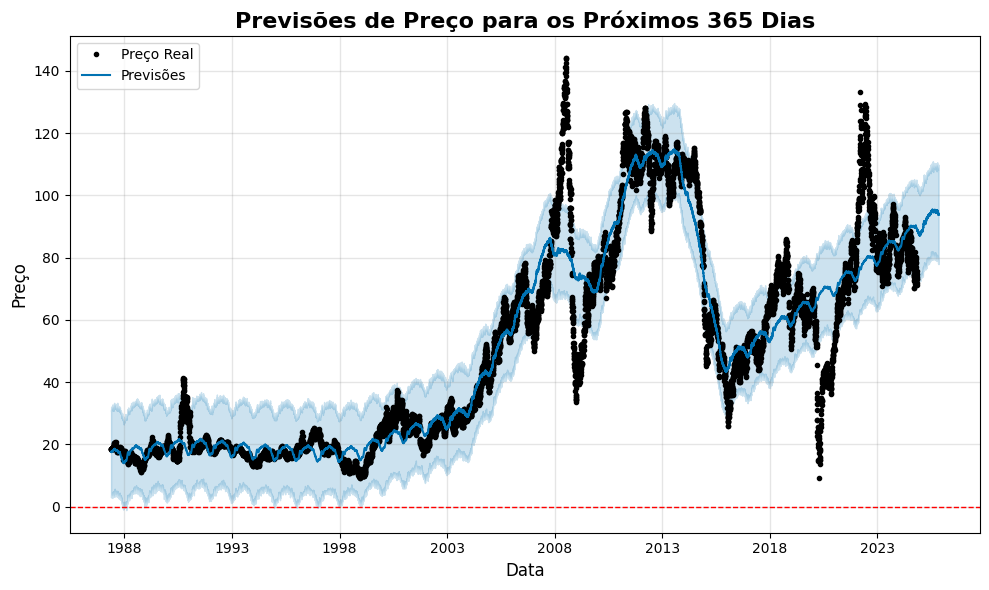

In [ ]:
fig = m.plot(forecast)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Título e rótulos
plt.title("Previsões de Preço para os Próximos 365 Dias", fontsize=16, fontweight='bold')
plt.xlabel("Data", fontsize=12)
plt.ylabel("Preço", fontsize=12)

plt.legend(['Preço Real', 'Previsões'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
predictions = forecast.iloc[-365:]['yhat']

Realizando o teste do primeiro modelo:

In [ ]:
print("Erro Quadrático Médio (Root Mean Squared Error) entre os valores reais e os valores previstos: ", rmse(predictions, test['y']))
print("Valor Médio do Conjunto de Dados de Teste: ", test['y'].mean())

Erro Quadrático Médio (Root Mean Squared Error) entre os valores reais e os valores previstos:  11.93224928363268
Valor Médio do Conjunto de Dados de Teste:  82.36912328767124


2º Modelo:

In [ ]:
# Crises
crises = pd.DataFrame([
    {'holiday': 'crise_2008', 'ds': '2008-07-07', 'lower_window': 0, 'ds_upper': '2008-12-31'},
    {'holiday': 'crise_2014', 'ds': '2014-06-01', 'lower_window': 0, 'ds_upper': '2015-01-01'},
    {'holiday': 'crise_2020', 'ds': '2020-02-01', 'lower_window': 0, 'ds_upper': '2021-03-01'},
    {'holiday': 'crise_2022', 'ds': '2022-01-01', 'lower_window': 0, 'ds_upper': '2022-12-31'},

])

for t_col in ['ds', 'ds_upper']:
    crises[t_col] = pd.to_datetime(crises[t_col])
crises['upper_window'] = (crises['ds_upper'] - crises['ds']).dt.days
crises

,holiday,ds,lower_window,ds_upper,upper_window
0,crise_2008,2008-07-07,0,2008-12-31,177
1,crise_2014,2014-06-01,0,2015-01-01,214
2,crise_2020,2020-02-01,0,2021-03-01,394
3,crise_2022,2022-01-01,0,2022-12-31,364


In [ ]:
m2 = Prophet(holidays=crises)
m2 = m2.fit(df)
future2 = m2.make_future_dataframe(periods=366)
forecast2 = m2.predict(future2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgq4rchxy/6eb5d2o_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgq4rchxy/cqfg1fn5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81427', 'data', 'file=/tmp/tmpgq4rchxy/6eb5d2o_.json', 'init=/tmp/tmpgq4rchxy/cqfg1fn5.json', 'output', 'file=/tmp/tmpgq4rchxy/prophet_modelshnwu2cm/prophet_model-20241130175147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:54:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


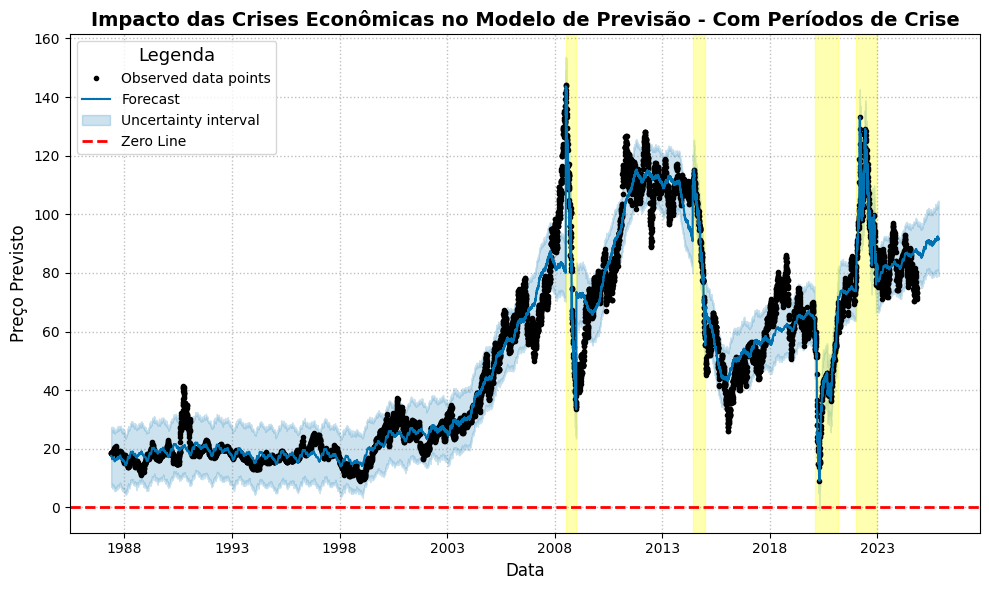

In [ ]:
# Plotando com melhorias estéticas
fig = m2.plot(forecast2)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Line')

# Melhorando a visualização da legenda
plt.legend(loc='upper left', fontsize=10, title="Legenda", title_fontsize='13')

# Adicionando título e labels
plt.title("Impacto das Crises Econômicas no Modelo de Previsão - Com Períodos de Crise", fontsize=14, weight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço Previsto', fontsize=12)

# Melhorando a exibição do gráfico
plt.grid(True, linestyle=':', alpha=0.5)

# Plotando os crises/crises no gráfico
for i, row in crises.iterrows():
    plt.axvspan(row['ds'], row['ds_upper'], color='yellow', alpha=0.3, label=f"Período de {row['holiday']}")

# Ajustando o layout para que tudo se ajuste melhor
plt.tight_layout()

# Exibindo o gráfico
plt.show()

In [ ]:
predictions2 = forecast2.iloc[-365:]['yhat']

Realizando o teste do segundo modelo:

In [ ]:
print("Erro Quadrático Médio entre os valores atuais e os valores previstos: ", rmse(predictions2, test['y']))
print("Valor médio do conjunto de dados de teste: ", test['y'].mean())


Erro Quadrático Médio entre os valores atuais e os valores previstos:  9.819782935993905
Valor médio do conjunto de dados de teste:  82.36912328767124


3º Modelo:

In [ ]:
crises = pd.DataFrame([
    {'holiday': 'guerra_golfo', 'ds': '1990-07-15', 'lower_window': 0, 'ds_upper': '1991-01-31'},
    {'holiday': 'crise_2008', 'ds': '2008-07-07', 'lower_window': 0, 'ds_upper': '2008-12-31'},
    {'holiday': 'crise_2014', 'ds': '2014-06-01', 'lower_window': 0, 'ds_upper': '2014-09-30'},
    {'holiday': 'crise_2020', 'ds': '2020-02-01', 'lower_window': 0, 'ds_upper': '2020-12-31'},
    {'holiday': 'crise_2022', 'ds': '2022-01-01', 'lower_window': 0, 'ds_upper': '2022-12-31'},

])

for t_col in ['ds', 'ds_upper']:
    crises[t_col] = pd.to_datetime(crises[t_col])
crises['upper_window'] = (crises['ds_upper'] - crises['ds']).dt.days
crises

,holiday,ds,lower_window,ds_upper,upper_window
0,guerra_golfo,1990-07-15,0,1991-01-31,200
1,crise_2008,2008-07-07,0,2008-12-31,177
2,crise_2014,2014-06-01,0,2014-09-30,121
3,crise_2020,2020-02-01,0,2020-12-31,334
4,crise_2022,2022-01-01,0,2022-12-31,364


In [ ]:
m3 = Prophet(holidays=crises)
m3.fit(df)
future3 = m3.make_future_dataframe(periods=365)
forecast3 = m3.predict(future3)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgq4rchxy/el2bgo70.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgq4rchxy/2yx5b8ka.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96340', 'data', 'file=/tmp/tmpgq4rchxy/el2bgo70.json', 'init=/tmp/tmpgq4rchxy/2yx5b8ka.json', 'output', 'file=/tmp/tmpgq4rchxy/prophet_model8pmawur8/prophet_model-20241130180157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:01:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


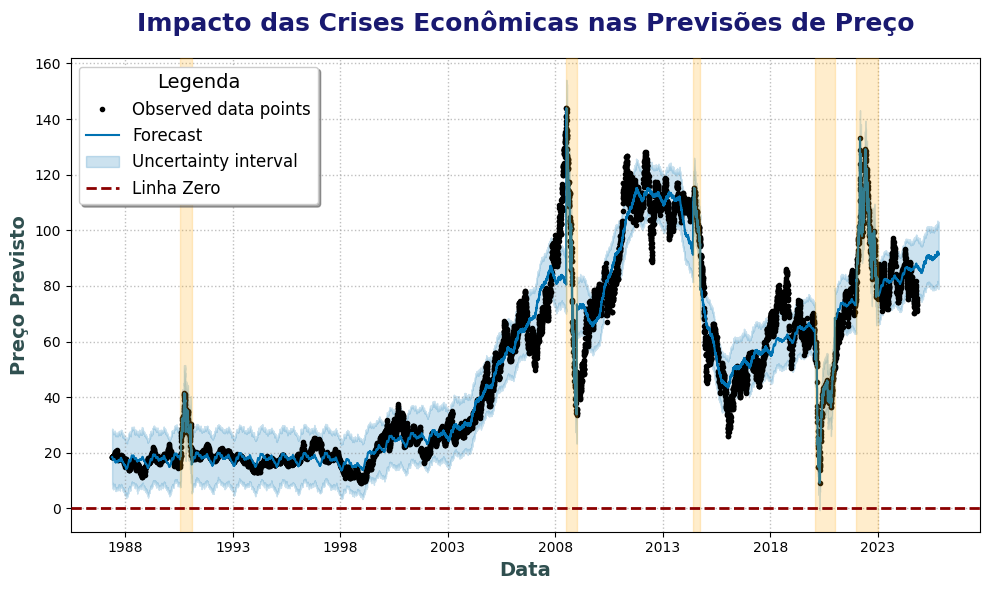

In [ ]:
fig = m3.plot(forecast3)

plt.axhline(y=0, color='darkred', linestyle='--', linewidth=2, label='Linha Zero', zorder=5)

plt.legend(loc='upper left', fontsize=12, title="Legenda", title_fontsize='14', frameon=True, shadow=True, fancybox=True)

plt.title("Impacto das Crises Econômicas nas Previsões de Preço", fontsize=18, weight='bold', color='midnightblue', pad=20)
plt.xlabel('Data', fontsize=14, weight='bold', color='darkslategray')
plt.ylabel('Preço Previsto', fontsize=14, weight='bold', color='darkslategray')

plt.grid(True, linestyle=':', color='gray', alpha=0.5)

for i, row in crises.iterrows():
    plt.axvspan(row['ds'], row['ds_upper'], color='orange', alpha=0.2, label=f"Período de {row['holiday']}", zorder=3)

plt.tight_layout()

plt.show()

In [ ]:
predictions3 = forecast3.iloc[-365:]['yhat']

Realizando o teste do terceiro modelo:

In [ ]:
print(f"Erro Quadrático Médio entre os valores reais e os valores previstos: {rmse(predictions3, test['y']):.2f}")
print(f"Valor médio do conjunto de dados de teste: {test['y'].mean():.2f}")


Erro Quadrático Médio entre os valores reais e os valores previstos: 9.60
Valor médio do conjunto de dados de teste: 82.37


Exportando para inclusão no Streamlit:

In [ ]:
joblib.dump(m3, 'prophet_model_final.pkl')

['prophet_model_final.pkl']